<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/2020-01-corona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [0]:
import pandas as pd
import numpy as np

# Data Taken from Our World in Data, update daily

In [0]:
# updated daily
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

time_series_df = pd.read_csv(url, 
                             sep=',', 
                             index_col=2, # you can use the date as the index for pandas
                             parse_dates=[0]) # where is the time stamp?

In [5]:
time_series_df.head()

,iso_code,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
date,,,,,,,,,,,,,,,
2020-03-13,ABW,Aruba,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-20,ABW,Aruba,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-24,ABW,Aruba,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-25,ABW,Aruba,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-26,ABW,Aruba,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN


# German Cases

In [6]:
df_germany = time_series_df[time_series_df['location'] == 'Germany']
df_germany.head()

,iso_code,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
date,,,,,,,,,,,,,,,
2019-12-31,DEU,Germany,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-01,DEU,Germany,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-02,DEU,Germany,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-03,DEU,Germany,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-04,DEU,Germany,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


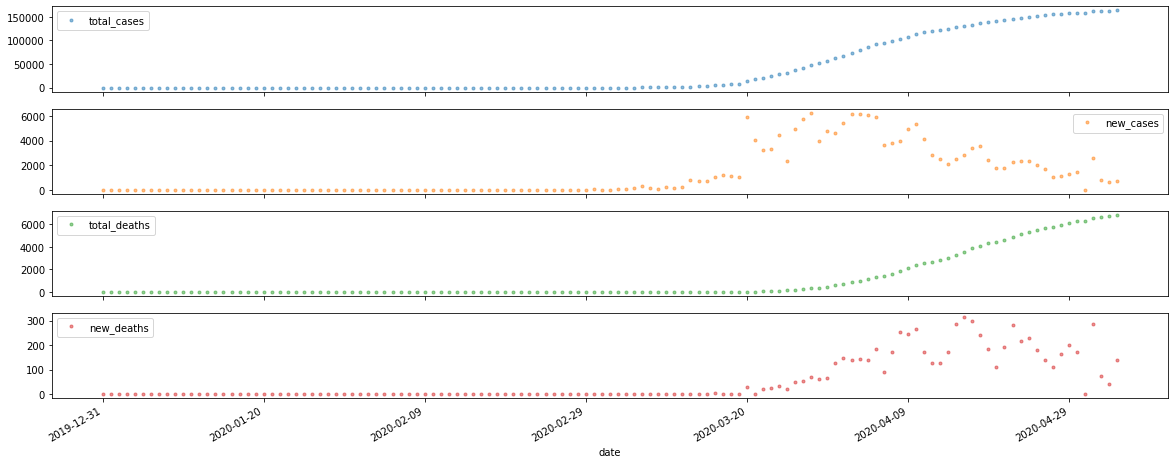

In [7]:
cols_plot = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths']

axes = df_germany[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True)

In [0]:
new_deaths_df = df_germany['new_deaths']
total_cases_df = df_germany['total_cases']
new_cases_df = df_germany['new_cases']
total_deaths_df = df_germany['total_deaths']

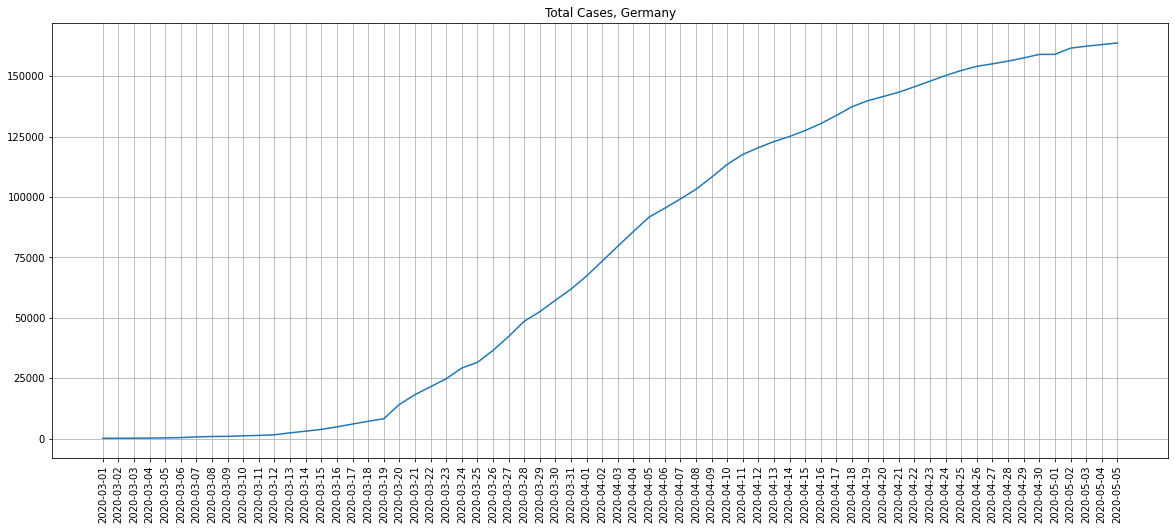

In [9]:
plt.plot(total_cases_df['2020-03-01':])
plt.xticks(rotation=90)
plt.title("Total Cases, Germany")
plt.grid()

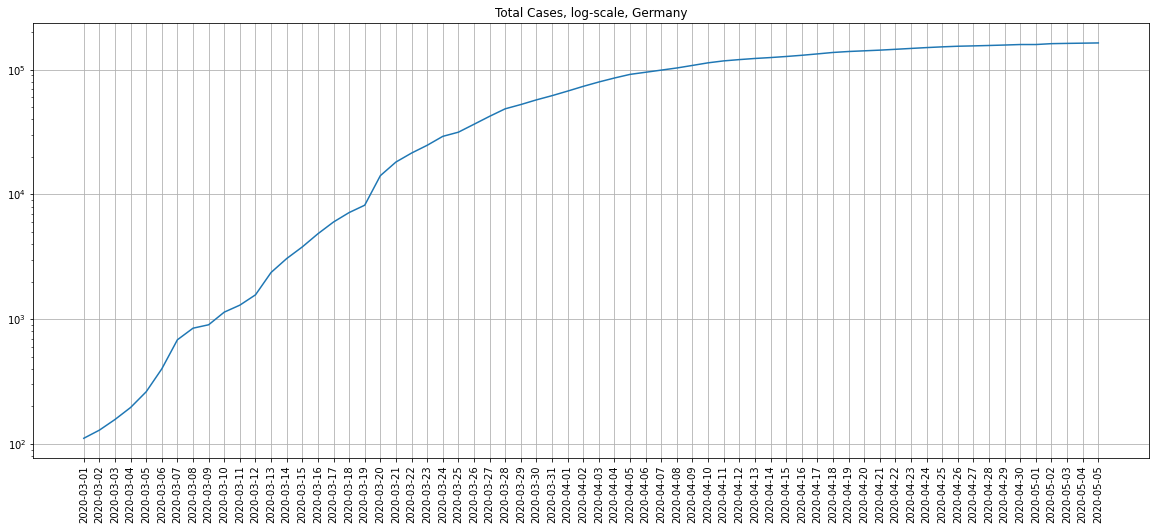

In [10]:
plt.plot(total_cases_df['2020-03-01':])
plt.xticks(rotation=90)
plt.title("Total Cases, log-scale, Germany")
plt.yscale('log')
plt.grid()

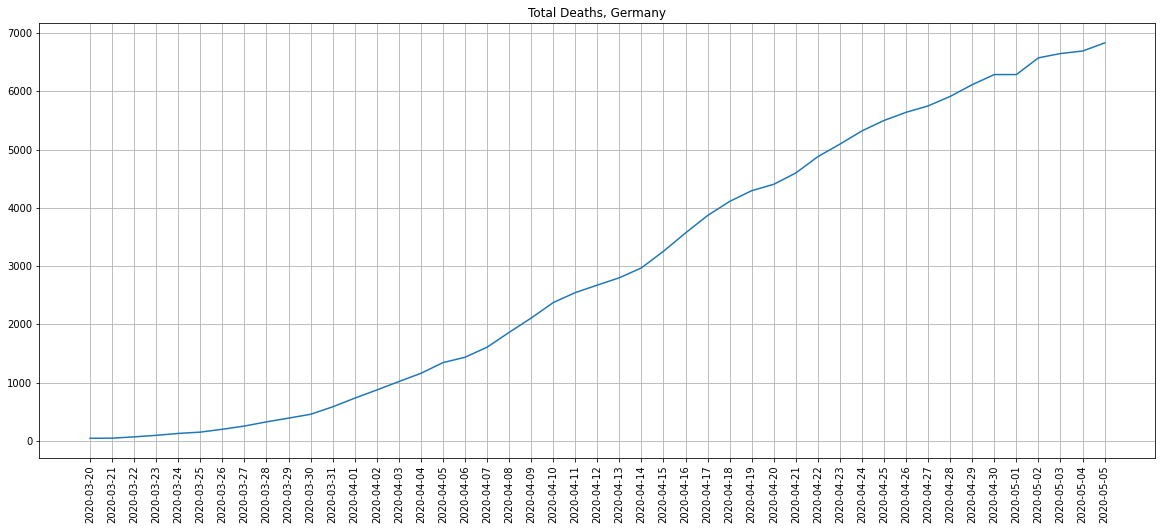

In [11]:
plt.plot(total_deaths_df['2020-03-20':])
plt.xticks(rotation=90)
plt.title("Total Deaths, Germany")
plt.grid()

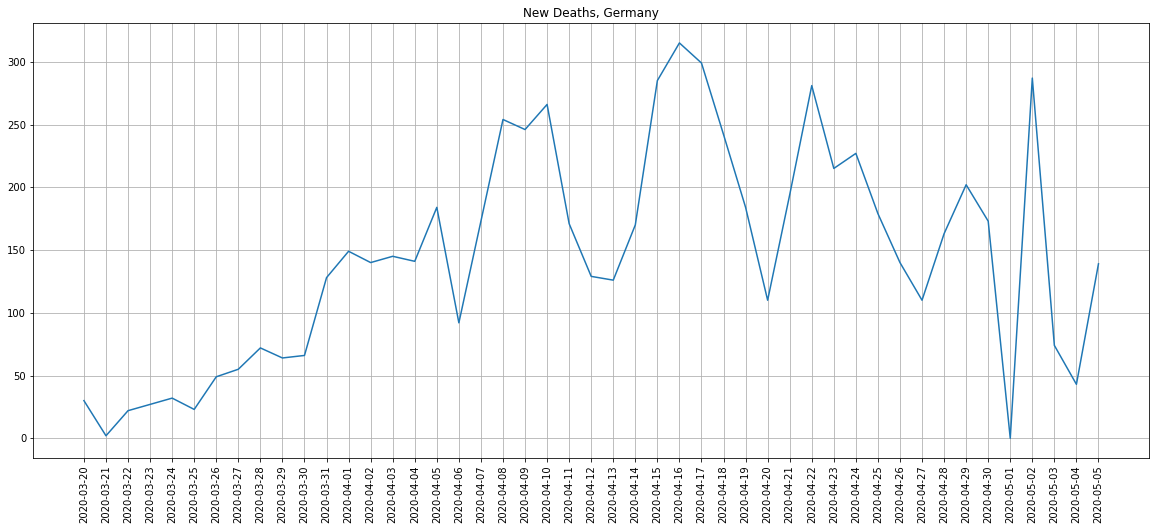

In [12]:
plt.plot(new_deaths_df['2020-03-20':])
plt.xticks(rotation=90)
plt.title("New Deaths, Germany")
plt.grid()

# UK Cases for comparison

In [0]:
uk_df = time_series_df[time_series_df['location'] == 'United Kingdom']

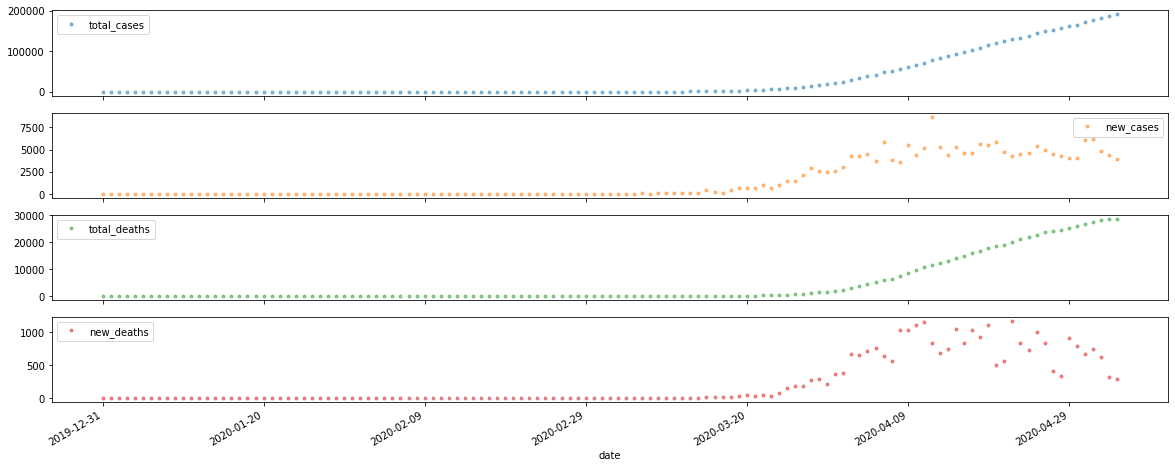

In [14]:
uk_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True);

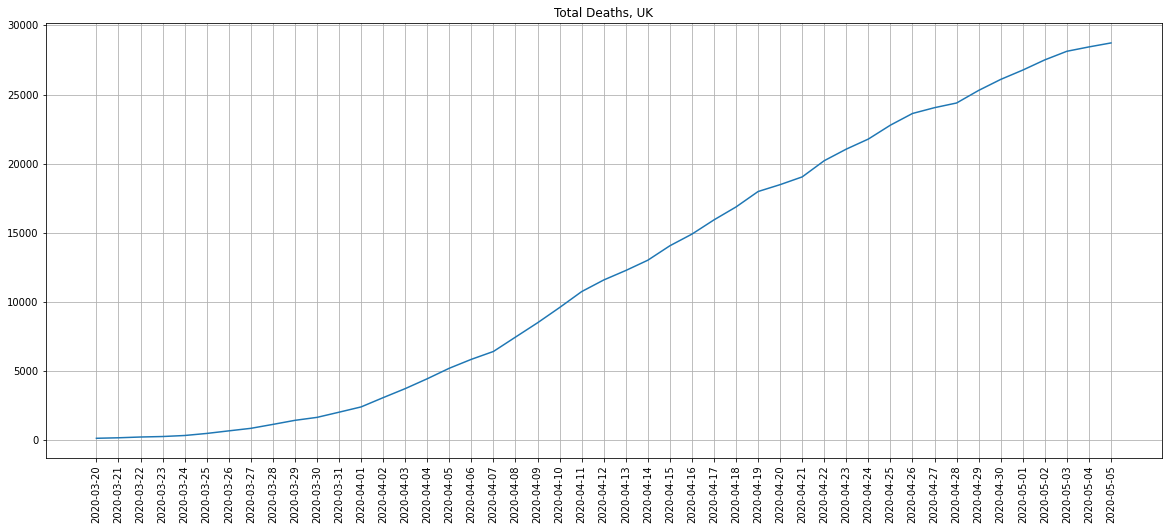

In [15]:
plt.plot(uk_df['total_deaths']['2020-03-20':])
plt.xticks(rotation=90)
plt.title("Total Deaths, UK")
plt.grid()

# Fitting German total Cases

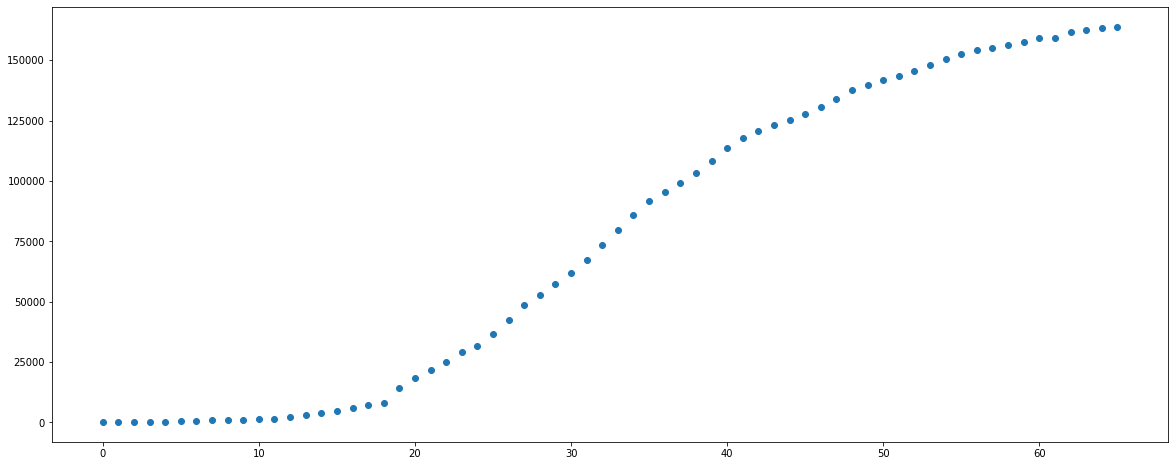

In [16]:
y = total_cases_df['2020-03-01':].values
x = np.arange(0, len(y), 1)
plt.scatter(x, y);

In [17]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.2.0-rc3'

In [0]:
tf.random.set_seed(42)

In [0]:
# https://keras.io/metrics/#custom-metrics
# https://www.tensorflow.org/tutorials/customization/performance
  
# ported to TF 2 from 
# * https://stackoverflow.com/a/42351397/1756489 and
# * https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019 (for use of epsilon to avoid strange inf or -inf)

@tf.function
def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, tf.add(total_error, tf.keras.backend.epsilon())))
  
  return R_squared

In [0]:
all_x = x
all_y = y

## Linear Model

In [21]:
start = 0
# end = -1
# start = 20
# end = 40
x = all_x[start:]
y = all_y[start:] / 1000
x.shape, y.shape

((66,), (66,))

In [22]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential([
  # Dense(units=1, input_dim=1, kernel_regularizer=tf.keras.regularizers.l2())                   
  Dense(units=1, input_dim=1)                   
])

model.compile(loss='mae',
            #  optimizer=tf.keras.optimizers.SGD(),
             optimizer=tf.keras.optimizers.Adam(0.1),
            #  optimizer=tf.keras.optimizers.Adam(),
             metrics=[r2_metric]) # we can track the r2 metric over time

history = model.fit(x, y, 
                    batch_size=1,
                    epochs=500,
                    verbose=0)
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(12.533782958984375, -762.9240112304688)

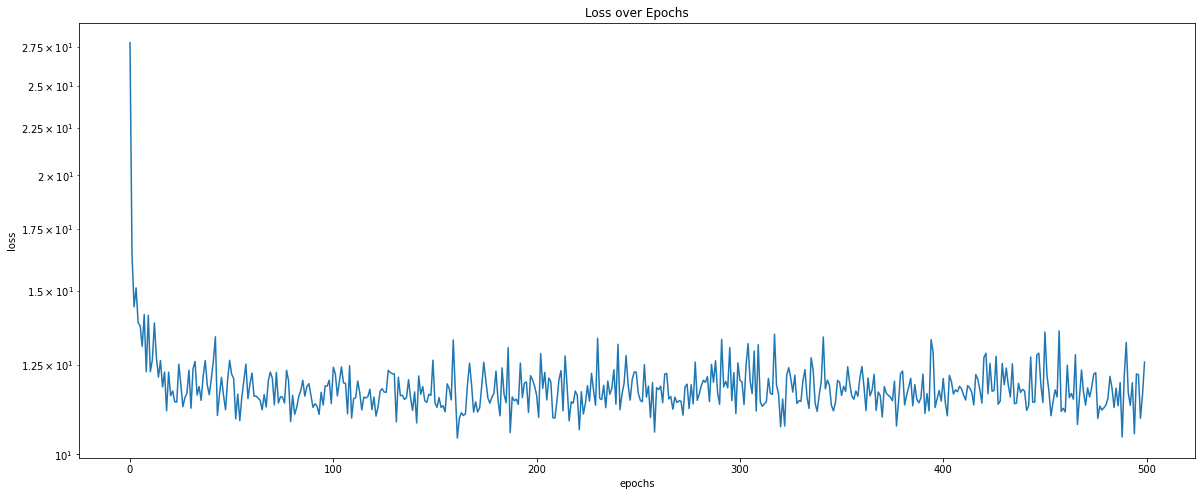

In [23]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs')

plt.plot(history.history['loss']);

In [24]:
from sklearn.metrics import r2_score

y_pred = model.predict(x)
r2 = r2_score(y, y_pred)
r2

0.9597589553437319

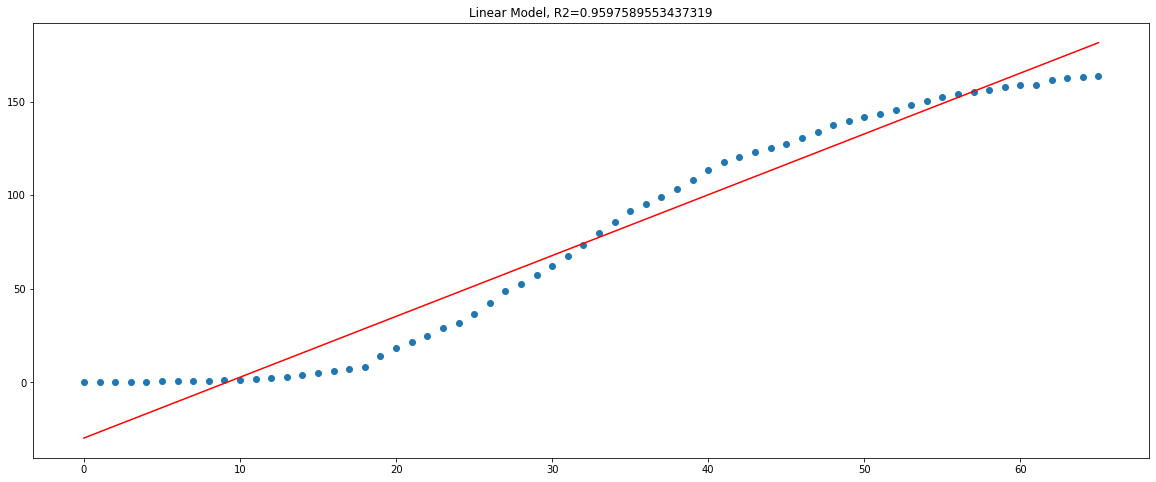

In [25]:
plt.title('Linear Model, R2={}'.format(r2))
plt.plot(x, y_pred, color='red')
# plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);

## S-Curve or completely free model

S-curve needs data to be normalized between 0 and 1 to match sigmoid activation

In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

start = 0
# end = -1
x = all_x[start:]
y =  MinMaxScaler().fit_transform(all_y[start:].reshape(-1, 1))
# y =  StandardScaler().fit_transform(all_y[start:].reshape(-1, 1))
# y = all_y[start:] / 1000

x.shape, y.shape

((66,), (66, 1))

In [27]:
y.min(), y.max()

(0.0, 1.0)

In [43]:
from tensorflow.keras.layers import Dense
 
# https://www.tensorflow.org/api_docs/python/tf/keras/activations/exponential
model = tf.keras.Sequential([
  # Dense(units=1, activation='linear', input_dim=1),                   
  # Dense(units=1, activation='sigmoid', input_dim=1),                   
  # Dense(units=5, activation='relu', input_dim=1),                   
  # Dense(units=5, activation='relu'),                   
  Dense(units=100, activation='relu', input_dim=1),
  Dense(units=100, activation='relu'),
  Dense(units=100, activation='relu'),                   
  Dense(units=1, activation='sigmoid'),                   
  # Dense(units=1, activation=tf.keras.activations.exponential),         
  # Dense(units=1, activation='tanh'),                   
  # Dense(units=1, activation='linear')                
])

model.compile(loss='mse',
             optimizer=tf.keras.optimizers.Adam(),
            #  optimizer=tf.keras.optimizers.Adam(0.1),
             metrics=[r2_metric]) # we can track the r2 metric over time

history = model.fit(x, y, 
                    # batch_size=1,
                    epochs=1000,
                    # epochs=500,
                    verbose=0)
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(0.0002402979152975604, -42.85842514038086)

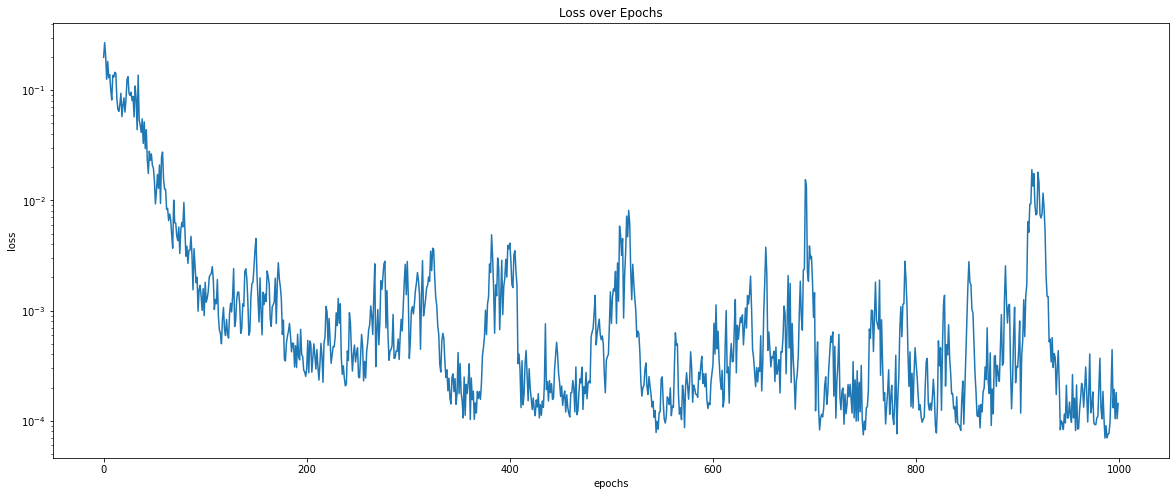

In [44]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs')

plt.plot(history.history['loss']);

In [45]:
from sklearn.metrics import r2_score

y_pred = model.predict(x)
r2 = r2_score(y, y_pred)
r2

0.9994092505632132

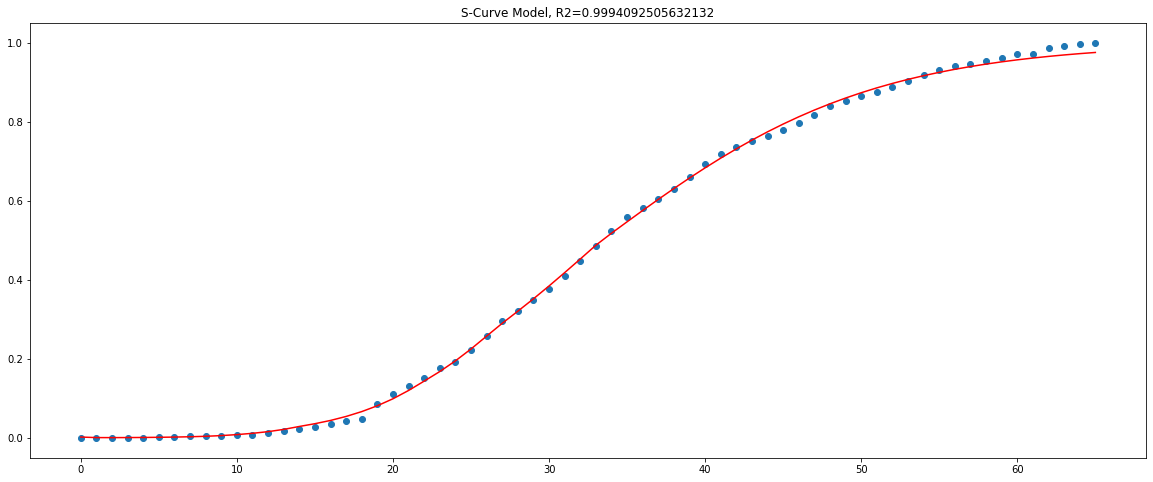

In [46]:
plt.title('S-Curve Model, R2={}'.format(r2))
plt.plot(x, y_pred, color='red')
# plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);

### Predicting the future (next 10 days)

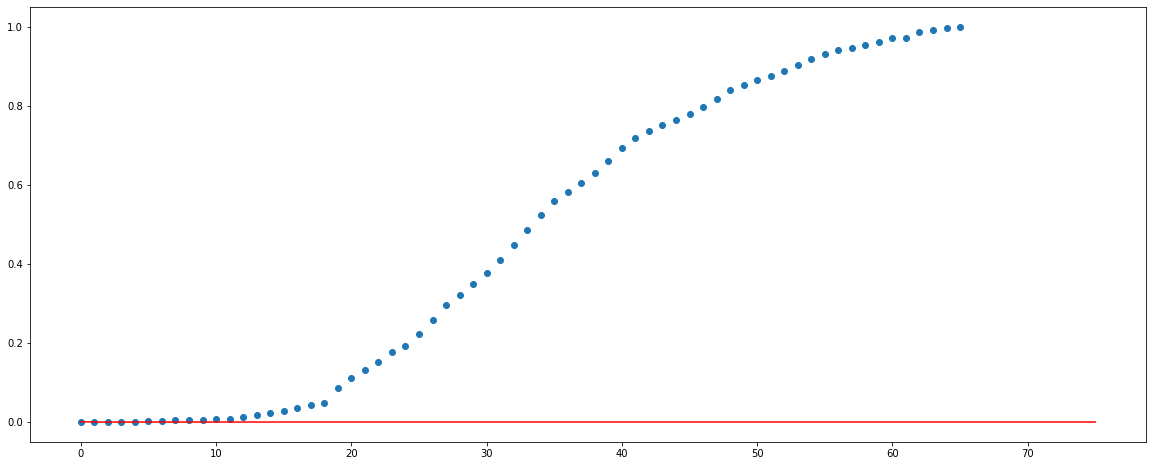

In [32]:
pred_x = np.arange(0, len(y) + 10, 1)
y_pred = model.predict(pred_x)
plt.plot(pred_x, y_pred, color='red')
# plt.scatter(pred_x, y_pred, color='red')
plt.scatter(x, y);

## RNN

In [0]:
# derived from here: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [0]:
#@title Prediction from n past days

# https://colab.research.google.com/notebooks/forms.ipynb

n_steps_in = 30 #@param {type:"slider", min:1, max:100, step:1}
n_steps_out = 1

In [35]:
X, Y = split_sequence(y, n_steps_in, n_steps_out)
X.shape, Y.shape

((36, 30, 1), (36, 1, 1))

In [36]:
# reshape from [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(36, 30, 1)

In [37]:
# we do a special test / train split, 
# we see how well we can predict 2017 as test/validation 

val_size = 5

X_train = X[:-val_size]
Y_train = Y[:-val_size]

X_test = X[-val_size:]
Y_test = Y[-val_size:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((31, 30, 1), (31, 1, 1), (5, 30, 1), (5, 1, 1))

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

model = Sequential()

# two layer model, known to work well
# model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu'))

# trains faster, but also works
# model.add(GRU(256, activation='relu', input_shape=(n_steps_in, n_features)))

# one layer SimpleRNN seems to be enough for this data set
model.add(SimpleRNN(256, activation='relu', input_shape=(n_steps_in, n_features), recurrent_dropout=0.1))

# horrible results
# model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(LSTM(64, activation='relu'))

# optional regularization
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# combines final outputs from RNN into continous output
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 256)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________


In [39]:
%%time

batch_size = 8
epochs=25

history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1)

Epoch 1/25
4/4 [==============================] - 0s 56ms/step - loss: 0.2307 - r2_metric: -7.1542 - val_loss: 0.0290 - val_r2_metric: -287.6314
Epoch 2/25
4/4 [==============================] - 0s 20ms/step - loss: 0.0289 - r2_metric: -0.2952 - val_loss: 1.5464e-04 - val_r2_metric: -0.5412
Epoch 3/25
4/4 [==============================] - 0s 23ms/step - loss: 0.0096 - r2_metric: 0.5476 - val_loss: 0.0174 - val_r2_metric: -172.5786
Epoch 4/25
4/4 [==============================] - 0s 20ms/step - loss: 0.0079 - r2_metric: 0.5276 - val_loss: 1.7451e-05 - val_r2_metric: 0.8261
Epoch 5/25
4/4 [==============================] - 0s 20ms/step - loss: 0.0030 - r2_metric: 0.8498 - val_loss: 0.0117 - val_r2_metric: -115.7408
Epoch 6/25
4/4 [==============================] - 0s 23ms/step - loss: 0.0042 - r2_metric: 0.8700 - val_loss: 4.1942e-04 - val_r2_metric: -3.1800
Epoch 7/25
4/4 [==============================] - 0s 20ms/step - loss: 0.0027 - r2_metric: 0.8344 - val_loss: 0.0014 - val_r2_met

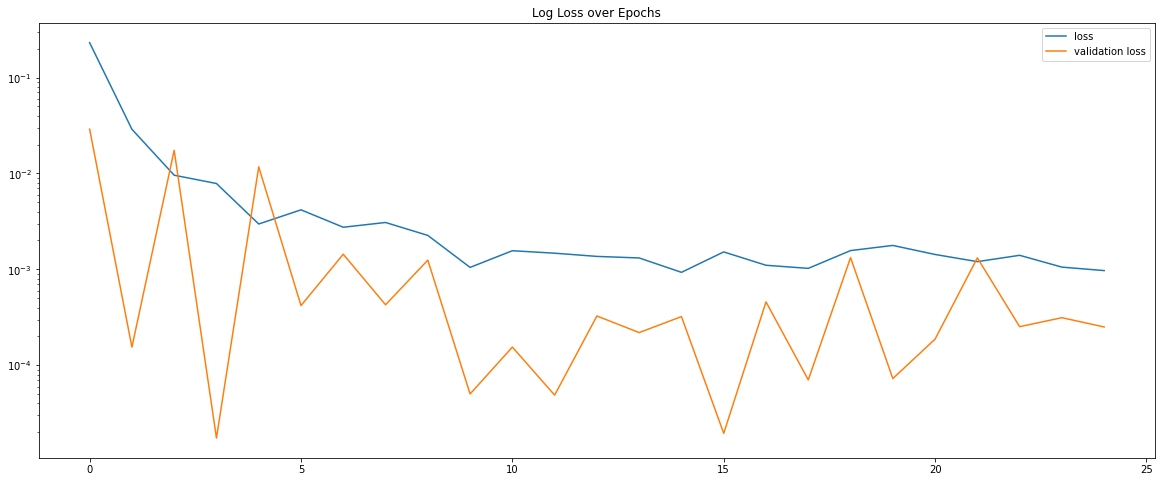

In [40]:
plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Log Loss over Epochs')

plt.legend(['loss', 'validation loss']);

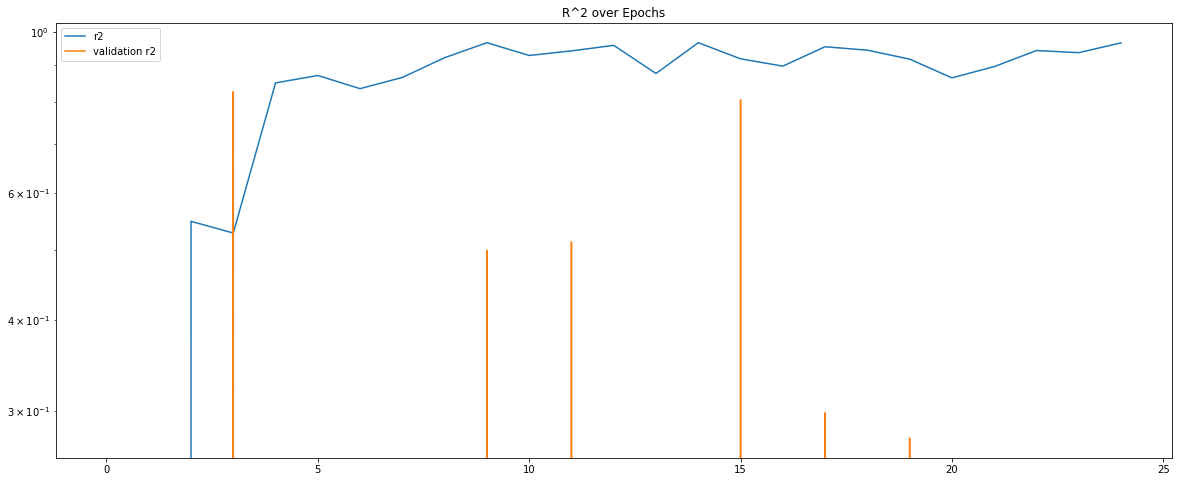

In [41]:
plt.yscale('log')
plt.plot(history.history['r2_metric'])
plt.plot(history.history['val_r2_metric'])
plt.title('R^2 over Epochs')

plt.legend(['r2', 'validation r2']);

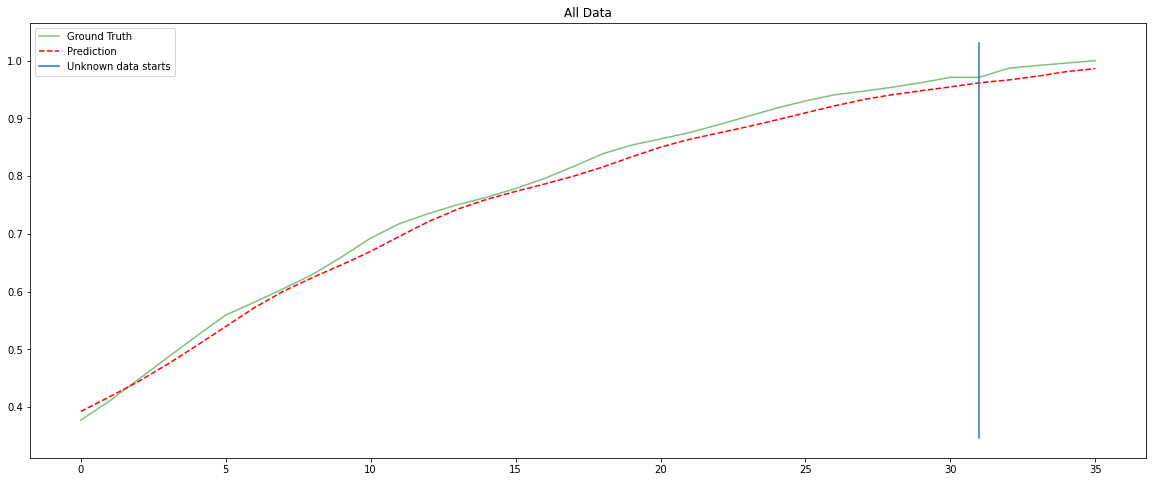

In [42]:
Y_pred = model.predict(X)
plt.title('All Data')
plt.plot(y[n_steps_in:], alpha=0.5, color='g', label='Ground Truth')
plt.plot(Y_pred, color='r', ls='dashed', label='Prediction')
plt.plot([len(Y_pred)-val_size, len(Y_pred)-val_size], plt.ylim(), label='Unknown data starts')
plt.legend()
